In [1]:
import csv, os, sys, json, datetime, collections
import numpy as np
import pandas as pd

## Import REPO library

 - https://github.com/GlobalFishingWatch/vessel-scoring
 - https://github.com/GlobalFishingWatch/training-data

In [2]:
sys.path.append('../vessel-scoring/vessel_scoring/')
sys.path.append('../vessel-scoring/')

In [3]:
import vessel_scoring.models
from vessel_scoring.models import train_model_on_data, load_data
from vessel_scoring import data, utils
import vessel_scoring.colspec
import vessel_scoring

In [4]:
def unix_time(timestamp):
    value = datetime.datetime.fromtimestamp(timestamp)
    return value.strftime('%Y-%m-%d %H:%M:%S')

### Read Simulate Data

In [5]:
!head -5 /net/account/pixuser/ryanchao2012/work/fishackathon/vessels_30.csv

tag,timestamp,longitude,latitude,uuid,type
outbound,1423076159,143.17084932128677,46.21757496612248,mmsi1,vessel
outbound,1423076751,142.7117034443558,46.362305287494,mmsi1,vessel
outbound,1423077484,142.60185236630696,46.10586137747794,mmsi1,vessel
outbound,1423078530,143.03972213434633,46.12358680189176,mmsi1,vessel


### Try Open Data

 - numpy savez_compressed format

In [6]:
test_track = np.load('/home/data/wayne_data/training-data/data/tracks/272873281811002.npz')

In [7]:
type(test_track['x'])

numpy.ndarray

In [8]:
test_track['x'].dtype

dtype([('mmsi', '<f8'), ('timestamp', '<f8'), ('distance_from_shore', '<f8'), ('distance_from_port', '<f8'), ('speed', '<f8'), ('course', '<f8'), ('lat', '<f8'), ('lon', '<f8')])

### Load DEMO Data

In [10]:
path = '/net/account/pixuser/ryanchao2012/work/fishackathon/vessels_30.csv'

In [11]:
with open(path, 'r') as f:
    reader = csv.reader(f)
    headers = reader.next()
    #for row in reader:

In [12]:
track_df = pd.read_csv(path)

In [13]:
track_df.dtypes

tag           object
timestamp      int64
longitude    float64
latitude     float64
uuid          object
type          object
dtype: object

In [14]:
track_df[0:3]

,tag,timestamp,longitude,latitude,uuid,type
0,outbound,1423076159,143.170849,46.217575,mmsi1,vessel
1,outbound,1423076751,142.711703,46.362305,mmsi1,vessel
2,outbound,1423077484,142.601852,46.105861,mmsi1,vessel


### Re-Format Data

In [15]:
track_df.columns = ['tag', 'timestamp', 'lon', 'lat', 'uuid','type']

In [16]:
track_df['distance_from_shore'] = 1.0
track_df['distance_from_port'] = 1.0
track_df['speed'] = 1.0
track_df['course'] = 1.0
track_df['mmsi'] = track_df.apply(lambda row: int(row.uuid[4:]), axis=1)

In [17]:
list(track_df.columns)

['tag',
 'timestamp',
 'lon',
 'lat',
 'uuid',
 'type',
 'distance_from_shore',
 'distance_from_port',
 'speed',
 'course',
 'mmsi']

In [18]:
x = np.zeros(len(track_df), dtype=[('timestamp', "<f8"),
                                   ('lon', "<f8"),
                                   ('lat', "<f8"),
                                   ('distance_from_shore', "<f8"),
                                   ('distance_from_port', "<f8"),
                                   ('speed', "<f8"),
                                   ('course', "<f8"),
                                   ('mmsi', "<f8")])

In [19]:
for _col in ['timestamp','lon','lat','distance_from_shore','distance_from_port',
            'speed','course','mmsi']: #track_df.columns:
    x[_col] = track_df[_col]

In [23]:
np.savez_compressed('qq_30.npz', x=x)

8

## Training Model

In [24]:
labeled_np = np.load('/net/account/pixuser/wayne/work/vessel-scoring/datasets/qq_30.npz')
labeled_np['x'].shape

(565866,)

In [25]:
labeled_df = pd.DataFrame(labeled_np['x'])

In [26]:
fieldnames = list(labeled_df.columns)

In [27]:
len(fieldnames)

91

In [28]:
X = np.zeros((x.shape[0], len(labeled_df.columns)))
y = np.zeros((x.shape[0]))

In [37]:
len(labeled_df.columns)

91

In [30]:
tag_dict = {}
for idx, tag in enumerate(set(list(track_df['tag']))):
    tag_dict[tag] = idx

In [31]:
for idx, row in labeled_df.iterrows():
    if row.isnull().values.any():
        continue
    this_dict = row.to_dict()
    is_fish = tag_dict[track_df['tag'][idx]]
    X[idx,] = [this_dict[elemt] for elemt in this_dict]
    y[idx] = is_fish

In [40]:
set(list(track_df['tag']))

{'fishing', 'inbound', 'outbound', 'trawling'}

In [33]:
import xgboost as xgb
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle


In [128]:
gbm = xgb.XGBClassifier(max_depth=1, n_estimators=1, learning_rate=0.5).fit(X, y)
predictions = gbm.predict(X)

In [129]:
set(list(y))

{0.0, 1.0, 2.0, 3.0}

In [131]:
score = metrics.accuracy_score(y, predictions)
print("accuracy:   %0.3f" % score)

print("confusion matrix:")
print(metrics.confusion_matrix(y, predictions))

accuracy:   0.993
confusion matrix:
[[    86    172      0    203]
 [     0   8429      0   1064]
 [     0      2    437      0]
 [     0   2380      2 553091]]


In [132]:
result = cross_val_score(gbm, X, y, 
                         cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=123))

In [134]:
predictions_proba = gbm.predict_proba(X)

In [137]:
set(list(y))

{0.0, 1.0, 2.0, 3.0}

In [138]:
y_onehot = label_binarize(y, classes=[0, 1, 2, 3])

In [140]:
roc_curve(y_onehot[:,0], predictions_proba[:,1])

(array([ 0.        ,  0.01912081,  0.01912081,  0.01989724,  0.99998408,  1.        ]),
 array([ 0.        ,  0.37310195,  0.55965293,  0.55965293,  0.73535792,  1.        ]),
 array([ 1.44446754,  0.4444676 ,  0.31156567,  0.30441806,  0.14775583,
         0.10741771], dtype=float32))

### Compute ROC curve and ROC area for each class

In [141]:
n_classes = y_onehot.shape[1]

In [142]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot[:, i], predictions_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot.ravel(), predictions_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [143]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

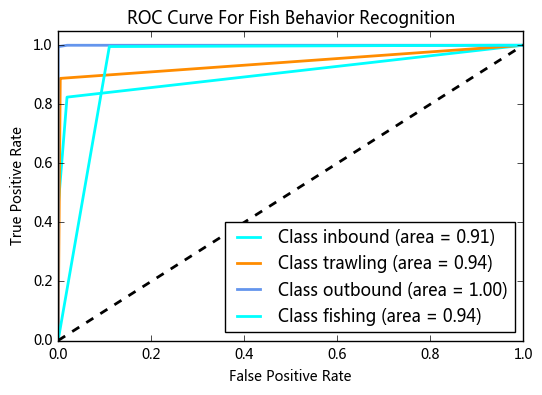

In [149]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
lw = 2
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
#plt.figure()
#plt.plot(fpr["micro"], tpr["micro"],
#         label='micro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["micro"]),
#         color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
#         label='macro-average ROC curve (area = {0:0.2f})'
#               ''.format(roc_auc["macro"]),
#         color='navy', linestyle=':', linewidth=4)

LABEL_CLASS = ['inbound','trawling','outbound','fishing']

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Class {0} (area = {1:0.2f})'
             ''.format(LABEL_CLASS[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve For Fish Behavior Recognition')
plt.legend(loc="lower right")
plt.show()

In [60]:
score = metrics.accuracy_score(y, predictions)
print("accuracy:   %0.3f" % score)

print("confusion matrix:")
print(metrics.confusion_matrix(y, predictions))

accuracy:   1.000
confusion matrix:
[[   461      0      0      0]
 [     0   9493      0      0]
 [     0      0    439      0]
 [     0      0      0 555473]]
